# Imports

In [1]:
import os
import urllib.request
from pathlib import Path
import PIL
import PIL.Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
from IPython.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

import numpy as np
from numpy import argmax
import random
import matplotlib.pyplot as plt
import pandas as pd

import os
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
import torch

import keras
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint,CSVLogger
import keras.backend as K
from keras import layers
from keras import backend
from keras import models
from keras import utils as keras_utils
from keras_applications import imagenet_utils
from keras_applications.imagenet_utils import decode_predictions
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.layers import Dense,Dropout,Conv2D,Input,MaxPool2D,Flatten,Activation, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D, Conv2D, Concatenate
from keras.models import Model
keras.backend.set_image_data_format('channels_last')

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.metrics import classification_report

import time
import warnings
warnings.filterwarnings("ignore")

# <center>EXPLORE Kaggle DATASET</center>

# Kaggle Dataset
https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset

## > Train

In [9]:
path = '../data/kaggle_yogaposes/DATASET/TRAIN/'  

# data = []
# folder = []
# thisdir = os.getcwd()

# for r, d, f in os.walk(path):    
#     for dic in d:
#         path1 = path + dic + '/'
#         for r2, d2, f2 in os.walk(path1):
#             for file in f2:
#                 data.append((dic, file))
            
# train_df = pd.DataFrame(data,columns=['YogaPoses','ImageNumbers'])
# train_df['label of class_6']= train_df['YogaPoses'].astype('category').cat.codes
# train_df['label of class_20'] = train_df['YogaPoses'].astype('category').cat.codes
# train_df['label of class_82'] = train_df['YogaPoses'].astype('category').cat.codes
# train_df.to_csv('../data/kaggle_yogaposes/DATASET/ALL/' + 'Train_df.csv')
train_df = pd.read_csv('../data/kaggle_yogaposes/DATASET/ALL/' + 'Train_df.csv')

In [10]:
print('classes in provided training data: ',len(train_df['YogaPoses'].unique()))

classes in provided training data:  5


## > Test

In [11]:
path = '../data/kaggle_yogaposes/DATASET/TEST/'  

# data = []
# folder = []
# thisdir = os.getcwd()

# for r, d, f in os.walk(path):    
#     for dic in d:
#         path1 = path + dic + '/'
#         for r2, d2, f2 in os.walk(path1):
#             for file in f2:
#                 data.append((dic, file))
            
# train_df = pd.DataFrame(data,columns=['YogaPoses','ImageNumbers'])
# train_df['label of class_6']= train_df['YogaPoses'].astype('category').cat.codes
# train_df['label of class_20'] = train_df['YogaPoses'].astype('category').cat.codes
# train_df['label of class_82'] = train_df['YogaPoses'].astype('category').cat.codes
#test_df.to_csv('../data/kaggle_yogaposes/DATASET/ALL/' + 'Test_df.csv')
test_df = pd.read_csv('../data/kaggle_yogaposes/DATASET/ALL/' + 'Test_df.csv')

In [5]:
print('classes in provided test data: ', len(test_df['YogaPoses'].unique()))

classes in provided test data:  5


In [6]:
test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]), train_df.shape[0] / (train_df.shape[0] + test_df.shape[0])

(0.3032839665164198, 0.6967160334835801)

In [12]:
test_df.shape[0], train_df.shape[0]

(471, 1082)

# Class balance

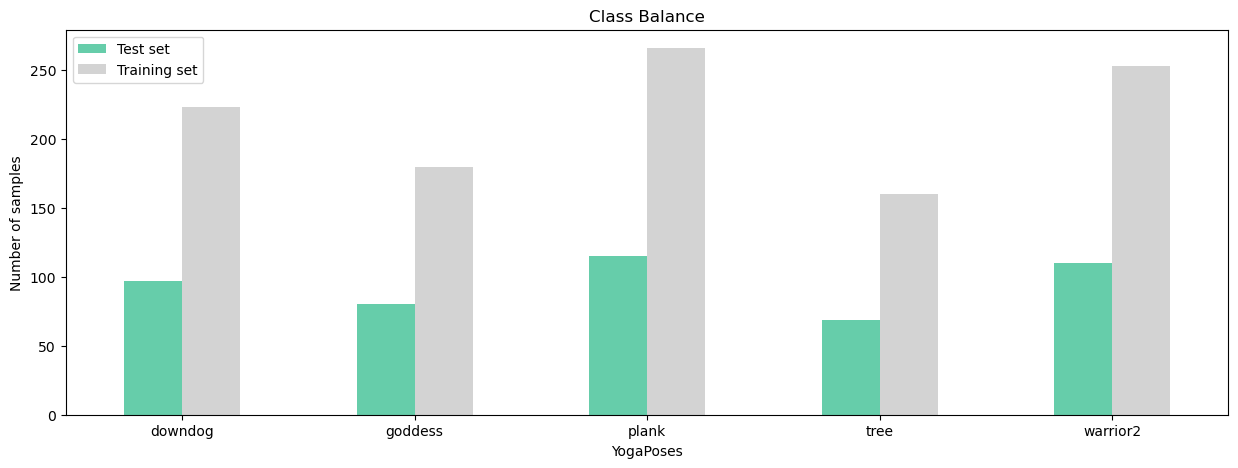

In [13]:
TestGrouped_df = test_df[['ImageNumbers', 'YogaPoses']].groupby(['YogaPoses']).count()
TrainGrouped_df = train_df[['ImageNumbers', 'YogaPoses']].groupby(['YogaPoses']).count()
df = pd.merge(TestGrouped_df, TrainGrouped_df, on='YogaPoses')
df = df.rename(columns={"ImageNumbers_x": "Test set", "ImageNumbers_y": "Training set"})
df['YogaPoses']=df.index
df.reset_index

df.plot.bar(x='YogaPoses', rot=90, figsize=(15,5), color=["mediumaquamarine", "lightgray"])
plt.ylabel('Number of samples')
plt.xticks(rotation = 0)
plt.title('Class Balance')
plt.savefig('../Plots/Kaggle/ClassBalance.jpg')

In [14]:
df['TestRatio'] = df['Test set'] / (df['Test set'] + df['Training set'])
df['TestRatio'].max(), df['TestRatio'].min()

(0.3076923076923077, 0.30131004366812225)

# <center>Modified Densenet-201 architecture</center>

In [15]:
'''CREATE TRIAL DATA TO BUILD THE MODEL'''

'''The model was run on the ITU HPC cluster with the entire data set.'''

TryTrain_df = train_df.groupby(['YogaPoses']).sample(8)
TryTest_df = test_df.groupby(['YogaPoses']).sample(2)

# keras_densenet_modified.py

This code is based on the git hub repository of: 

Verma, M., Kumawat, S., Nakashima, Y., & Raman, S. (2020). Yoga-82: a new dataset for fine-grained classification of human poses. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (pp. 1038-1039).

https://github.com/maniver7/yoga-82

In [11]:
BASE_WEIGTHS_PATH = (
    'https://github.com/keras-team/keras-applications/')

DENSENET201_WEIGHT_PATH_NO_TOP = (
    BASE_WEIGTHS_PATH +
    'densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5')

def dense_block(x, blocks, name):
    """A dense block.

    # Arguments
        x: input tensor.
        blocks: integer, the number of building blocks.
        name: string, block label.

    # Returns
        output tensor for the block.
    """
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x


def transition_block(x, reduction, name):
    """A transition block.

    # Arguments
        x: input tensor.
        reduction: float, compression rate at transition layers.
        name: string, block label.

    # Returns
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                  name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    x = layers.Conv2D(int(backend.int_shape(x)[bn_axis] * reduction), 1,
                      use_bias=False,
                      name=name + '_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x


def conv_block(x, growth_rate, name):
    """A building block for a dense block.

    # Arguments
        x: input tensor.
        growth_rate: float, growth rate at dense layers.
        name: string, block label.

    # Returns
        Output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    x1 = layers.BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x


def DenseNet(blocks,
             include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    """Instantiates the DenseNet architecture.

    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.

    # Arguments
        blocks: numbers of building blocks for the four dense layers.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `'channels_last'` data format)
            or `(3, 224, 224)` (with `'channels_first'` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 32.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    #global backend, layers, models, keras_utils
    #backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
    x = layers.Activation('relu', name='conv1/relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)

    x = dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[1], name='conv3')
    
    x = transition_block(x, 0.5, name='pool3')
    x1=x
    x = dense_block(x, blocks[2], name='conv4')
    
    x = transition_block(x, 0.5, name='pool4')
    x2=x
    x = dense_block(x, blocks[3], name='conv5')

    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = layers.Activation('relu', name='relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = tf.keras.utils.get_source_inputs(input_tensor) #tf.keras.utils.get_source_inputs
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, [x1,x2,x], name='densenet201_hir')
    
    # Load weights.
    
    if weights == 'imagenet':
        
        weights_path = keras_utils.get_file(
            'densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5',
            DENSENET201_WEIGHT_PATH_NO_TOP,
            cache_subdir='models',
            file_hash='c13680b51ded0fb44dff2d8f86ac8bb1')

        model.load_weights(weights_path)
    #elif weights is not None:
    #    model.load_weights(weights)

    return model

def DenseNet201_hir(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    return DenseNet([6, 12, 48, 32],
                    include_top, weights,
                    input_tensor, input_shape,
                    pooling, classes,
                    **kwargs)


def preprocess_input(x, data_format=None, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.

    # Arguments
        x: a 3D or 4D numpy array consists of RGB values within [0, 255].
        data_format: data format of the image tensor.

    # Returns
        Preprocessed array.
    """
    return imagenet_utils.preprocess_input(x, data_format,
                                           mode='torch', **kwargs)

setattr(DenseNet201_hir, '__doc__', DenseNet.__doc__)

# models.py
This code is based on the git hub repository of: 

Verma, M., Kumawat, S., Nakashima, Y., & Raman, S. (2020). Yoga-82: a new dataset for fine-grained classification of human poses. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (pp. 1038-1039).

https://github.com/maniver7/yoga-82

In [12]:
def dense_block(x, blocks, name):
    """A dense block.
    # Arguments
        x: input tensor.
        blocks: integer, the number of building blocks.
        name: string, block label.
    # Returns
        output tensor for the block.
    """
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))
    return x


def conv_block(x, growth_rate, name):
    """A building block for a dense block.
    # Arguments
        x: input tensor.
        growth_rate: float, growth rate at dense layers.
        name: string, block label.
    # Returns
        Output tensor for the block.
    """
    bn_axis = 3 #if backend.image_data_format() == 'channels_last' else 1
    x1 = BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = Concatenate(axis=bn_axis, name=name + '_concat')([x, x1])
    return x

def model_one_class(
        input_shape = (224,224,3),
        class_6=6,
        class_20=20,
        class_82=82):
    # for results of sota papers
    inputs = Input(input_shape)
    
    base_model= DenseNet121(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    

    x=  base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(class_82, activation='softmax')(x)

    model = Model(inputs=inputs, outputs= [x])

    for layer in base_model.layers:
        layer.trainable = True
    
    return model


def dense201_hirar(
        input_shape = (224,224,3),
        class_6=6,
        class_20=20,
        class_82=82):
    
    # for variant 1 in the paper

    inputs = Input(input_shape)
    base_model= DenseNet201_hir(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
   
    [x1,x2,x] = base_model.output

    x1 = BatchNormalization( epsilon=1.001e-5, name = 'bn_class6_last')(x1)
    x1 = Activation('relu', name='relu_class6_last')(x1)                                                                                                                                                                                                                                                                    
    x1 = GlobalAveragePooling2D(name='GAvgPool_class6_last')(x1)
    x2 = BatchNormalization( epsilon=1.001e-5, name = 'bn_class20_last')(x2)
    x2 = Activation('relu', name='relu_class20_last')(x2)
    x2 = GlobalAveragePooling2D(name='GAvgPool_class20_last')(x2)
    x = GlobalAveragePooling2D()(x)

    x1 = Dense(class_6, activation= 'softmax')(x1)
    x2 = Dense(class_20, activation= 'softmax')(x2)
    x = Dense(class_82, activation='softmax')(x)

    model = Model(inputs, [x1,x2,x])

    for layer in base_model.layers:
        layer.trainable = True
    
    return model

def dense201_hirar_6same20(
        input_shape = (224,224,3),
        class_6=6,
        class_20=20,
        class_82=82):
    
    # for variant 2 in the paper
    inputs = Input(input_shape)
    base_model= DenseNet201_hir(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)

    [null,x2,x] = base_model.output

    x1 = BatchNormalization(epsilon=1.001e-5, name = 'bn_class6_last')(x2)
    x1 = Activation('relu', name='relu_class6_last')(x1)
    x1 = GlobalAveragePooling2D(name='GAvgPool_class6_last')(x1)
    x2 = BatchNormalization(epsilon=1.001e-5, name = 'bn_class20_last')(x2)
    x2 = Activation('relu', name='relu_class20_last')(x2)
    x2 = GlobalAveragePooling2D(name='GAvgPool_class20_last')(x2)
    x = GlobalAveragePooling2D()(x)

    x1 = Dense(class_6, activation= 'softmax')(x1)

    x2 = Dense(class_20, activation= 'softmax')(x2)

    x = Dense(class_82, activation='softmax')(x)

    model = Model(inputs, [x1,x2,x])

    for layer in base_model.layers:
        layer.trainable = True
    
    return model


def dense201_hirar_new(
        input_shape = (224,224,3),
        class_6=6,
        class_20=20,
        class_82=82):

    # for variant 3 in the paper

    inputs = Input(input_shape)
    base_model= DenseNet201_hir(include_top=False, weights=None, input_tensor = inputs, backend = keras.backend , layers = keras.layers , models = keras.models , utils = keras.utils)
    
    [x1,x2,x] = base_model.output

    x1 = dense_block(x1, 32, name='denseblockClass6')


    x1 = BatchNormalization( epsilon=1.001e-5, name = 'bn_class6_last')(x1)
    x1 = Activation('relu', name='relu_class6_last')(x1)
    x1 = GlobalAveragePooling2D(name='GAvgPool_class6_last')(x1)
    x2 = BatchNormalization( epsilon=1.001e-5, name = 'bn_class20_last')(x2)
    x2 = Activation('relu', name='relu_class20_last')(x2)
    x2 = GlobalAveragePooling2D(name='GAvgPool_class20_last')(x2)
    x = GlobalAveragePooling2D()(x)

    x1 = Dense(class_6, activation= 'softmax')(x1)

    x2 = Dense(class_20, activation= 'softmax')(x2)

    x = Dense(class_82, activation='softmax')(x)

    model = Model(inputs, [x1,x2,x])

    for layer in base_model.layers:
        layer.trainable = True
    
    return model

# train_yoga.py

This code is the modification of the code from the git hub repository of: 

Verma, M., Kumawat, S., Nakashima, Y., & Raman, S. (2020). Yoga-82: a new dataset for fine-grained classification of human poses. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (pp. 1038-1039).

https://github.com/maniver7/yoga-82

In [13]:
def preprocess(inputs):
    inputs /=255
    return inputs


def process_data(df,img_path,train=True):
    num = df.shape[0]
    
    data = np.zeros((num,224,224,3),dtype='float32')
    x1_labels = np.zeros(num,dtype='int')
    x2_labels = np.zeros(num,dtype='int')
    x3_labels = np.zeros(num,dtype='int')

    for i in range(num):
        path = df['YogaPoses'].iloc[i] + '/' + df['ImageNumbers'].iloc[i]
        
        x1_label = df['label of class_6'].iloc[i]
        x2_label = df['label of class_20'].iloc[i]
        x3_label = df['label of class_82'].iloc[i]

        imgs = img_path + path
        if train:
                image = PIL.Image.open(imgs).convert("RGB")
                image = image.resize((224,224), PIL.Image.ANTIALIAS)
                data[i][:][:][:] = image
                x1_labels[i] = x1_label
                x2_labels[i] = x2_label
                x3_labels[i] = x3_label
            
        else:
            image = PIL.Image.open(imgs).convert("RGB")
            image = image.resize((224,224), PIL.Image.ANTIALIAS)
            data[i][:][:][:] = image
            x1_labels[i] = x1_label
            x2_labels[i] = x2_label
            x3_labels[i] = x3_label
    
    return data, x1_labels, x2_labels, x3_labels


def generator_train_batch(df,batch_size,num_classes,img_path):
    
    class_6 = num_classes[0]
    class_20 = num_classes[1]
    class_82 = num_classes[2]
    while True:
        
            df_shuffled = df.sample(frac=1, random_state=4)
            num = df_shuffled.shape[0]
            for i in range(0, num, batch_size):
                x_train, x1_labels, x2_labels, x3_labels = process_data(df_shuffled[i:(i+batch_size)],img_path,train=True)
                x = preprocess(x_train)
                y1 = np_utils.to_categorical(np.array(x1_labels), class_6)
                y2 = np_utils.to_categorical(np.array(x2_labels), class_20)
                y3 = np_utils.to_categorical(np.array(x3_labels), class_82)
                y = [y1,y2,y3]
                yield x, y

def generator_val_batch(df,batch_size,num_classes,img_path):
    class_6 = num_classes[0]
    class_20 = num_classes[1]
    class_82 = num_classes[2]
    
    while True:
            num = df.shape[0]
            for i in range(0,num,batch_size):
                y_test,y1_labels, y2_labels, y3_labels = process_data(df[i:(i+batch_size)],img_path,train=False)
                x = preprocess(y_test)
                y1 = np_utils.to_categorical(np.array(y1_labels), class_6)
                y2 = np_utils.to_categorical(np.array(y2_labels), class_20)
                y3 = np_utils.to_categorical(np.array(y3_labels), class_82)
                test_data = x
                y = [y1,y2,y3]
                yield test_data, y

# Variant 1

In [14]:
def main():
    path = '../Results/Results_KAGGLE_TRY/dense201_hirar/'
    img_path = '../data/kaggle_yogaposes/DATASET/ALL/' 
    
    test_df = TryTest_df
    train_df = TryTrain_df
    
    num_classes = [6,20,82]
    batch_size = 10 #32  #164 training samples, 82 test
    epochs = 2

    model = dense201_hirar()
    #model.load_weights('weights_betweenhirarModify_lw111_6and20ConnectSame_nopre_mix_.0003.hdf5')

    lr = 0.003 # orig= 0.003
    sgd = SGD(learning_rate=lr, momentum=0.9, nesterov=False)
    #adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], loss_weights=[1,1,1], optimizer= sgd, metrics=['accuracy'])#, 'top_k_categorical_accuracy'])
    
    # fix random seed for reproducibility
    #seed = 7
    #tf.random.set_seed(seed)
    
    
    #model.summary()
    # Open the file
    #with open(filename + 'modelSummary_V2.txt','w') as fh:
        # Pass the file handle in as a lambda function to make it callable
        #model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
    csv_logger= CSVLogger(path + 'log_V1.csv')
    #callbacks = [checkpoint]


    # get the start time
    st = time.time()
    #save the Keras model or model weights at some frequency.
    # "val_loss" to monitor the model's total loss.
    #verbose: 1 displays messages when the callback takes an action.
    model.fit_generator(generator_train_batch(train_df, batch_size, num_classes,img_path),
                          steps_per_epoch = train_df.shape[0] // batch_size + 1,
                          epochs=epochs,
                          callbacks=[csv_logger],
                          validation_data=generator_val_batch(test_df, batch_size,num_classes,img_path),
                          validation_steps = test_df.shape[0] // batch_size + 1,
                          verbose=1)
    np.save(path + 'model_weights_V1.npy',model.get_weights())
    print('FIT ENDED')
    # get the end time
    et = time.time()
    # get execution time in minutes
    res = et - st
    final_res = res / 60
    print('Execution time:', final_res, 'minutes')

    model = dense201_hirar()
    model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], loss_weights=[1,1,1], optimizer= sgd, metrics=['accuracy'])#, 'top_k_categorical_accuracy'])
    model.set_weights(np.load(path + 'model_weights_V1.npy', allow_pickle=True))
    
    batch_size = 5
    test_steps_per_epoch = test_df.shape[0] // 5
    
    score = model.evaluate_generator(generator_val_batch(test_df,batch_size,num_classes,img_path),steps=test_steps_per_epoch, verbose=1)
    np.savetxt(path + 'score_V1.txt', score, fmt = '%d')
    ###################################################################
    #generate predictions
    y_predg = model.predict_generator(generator_val_batch(test_df, batch_size, num_classes, img_path), steps=test_steps_per_epoch, verbose=2)

    np.savetxt(path + 'probabilities6_V2.txt', y_predg[0], fmt = '%d')
    np.savetxt(path + 'probabilities20_V2.txt', y_predg[1], fmt = '%d')
    np.savetxt(path + 'probabilities82_V2.txt', y_predg[2], fmt = '%d')

    predictions6 = np.argmax(y_predg[0],axis=1)
    np.savetxt(path + 'predictions6.txt', predictions6, fmt='%d')
    predictions20 = np.argmax(y_predg[1],axis=1)
    np.savetxt(path + 'predictions20.txt', predictions20, fmt='%d')
    predictions82 = np.argmax(y_predg[2],axis=1)
    np.savetxt(path + 'predictions82.txt', predictions82, fmt='%d')
    #get true labels
    y_testlabels6 = np_utils.to_categorical(np.array(test_df['label of class_6']), 6)
    y_testlabels20 = np_utils.to_categorical(np.array(test_df['label of class_20']), 20)
    y_testlabels82 = np_utils.to_categorical(np.array(test_df['label of class_82']), 82)

    # confusion matrix
    cm = tf.math.confusion_matrix(np.argmax(y_testlabels6,axis=1), predictions6, 6)
    torch.save(cm, path + 'cm6.pt')
    cm = tf.math.confusion_matrix(np.argmax(y_testlabels20,axis=1), predictions20, 20)
    torch.save(cm, path + 'cm20.pt')
    cm = tf.math.confusion_matrix(np.argmax(y_testlabels82,axis=1), predictions82, 82)
    torch.save(cm, path + 'cm82.pt')

    #classification reports
    
    report = classification_report(y_testlabels6.argmax(axis=1), predictions6, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(path + 'classification_report6.csv')

    report = classification_report(y_testlabels20.argmax(axis=1), predictions20, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(path + 'classification_report20.csv')

    report = classification_report(y_testlabels82.argmax(axis=1), predictions82, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(path + 'classification_report82.csv')


if __name__ == '__main__':
    main()


Epoch 1/2
5/5 [==============================] - 65s 8s/step - loss: 8.5096 - dense_loss: 1.8404 - dense_1_loss: 2.9419 - dense_2_loss: 3.7273 - dense_accuracy: 0.1800 - dense_1_accuracy: 0.0800 - dense_2_accuracy: 0.1600 - val_loss: 9.0132 - val_dense_loss: 1.8280 - val_dense_1_loss: 2.9772 - val_dense_2_loss: 4.2080 - val_dense_accuracy: 0.0000e+00 - val_dense_1_accuracy: 0.2000 - val_dense_2_accuracy: 0.2000
Epoch 2/2
5/5 [==============================] - 35s 7s/step - loss: 5.6156 - dense_loss: 1.7120 - dense_1_loss: 1.9669 - dense_2_loss: 1.9367 - dense_accuracy: 0.2400 - dense_1_accuracy: 0.3200 - dense_2_accuracy: 0.3000 - val_loss: 8.4149 - val_dense_loss: 1.8406 - val_dense_1_loss: 2.8057 - val_dense_2_loss: 3.7687 - val_dense_accuracy: 0.1000 - val_dense_1_accuracy: 0.2000 - val_dense_2_accuracy: 0.2000
FIT ENDED
Execution time: 1.678315532207489 minutes
2/2 [==============================] - 8s 847ms/step - loss: 8.4149 - dense_3_loss: 1.8406 - dense_4_loss: 2.8057 - dense_

# Variant 2


In [15]:
def main():
    path = '../Results/Results_KAGGLE_TRY/dense201_hirar_6same20/'
    img_path = '../data/kaggle_yogaposes/DATASET/ALL/' 
    
    test_df = TryTest_df
    train_df = TryTrain_df
    
    num_classes = [6,20,82]
    batch_size = 10 #32  #164 training samples, 82 test
    epochs = 2

    model = dense201_hirar_6same20()

    lr = 0.003 
    sgd = SGD(learning_rate=lr, momentum=0.9, nesterov=False)
    #adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], loss_weights=[1,1,1], optimizer= sgd, metrics=['accuracy'])#, 'top_k_categorical_accuracy'])
    
    #model.summary()
    # Open the file
    #with open(filename + 'modelSummary_V2.txt','w') as fh:
        # Pass the file handle in as a lambda function to make it callable
        #model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
    csv_logger= CSVLogger(path + 'log_V3.csv')
    #callbacks = [checkpoint]

    # get the start time
    st = time.time()
    #save the Keras model or model weights at some frequency.
    # "val_loss" to monitor the model's total loss.
    #verbose: 1 displays messages when the callback takes an action.
    model.fit_generator(generator_train_batch(train_df, batch_size, num_classes,img_path),
                          steps_per_epoch = train_df.shape[0] // batch_size + 1,
                          epochs=epochs,
                          callbacks=[csv_logger],
                          validation_data=generator_val_batch(test_df, batch_size,num_classes,img_path),
                          validation_steps = test_df.shape[0] // batch_size + 1,
                          verbose=1)
    np.save(path + 'model_weights_V1.npy',model.get_weights())
    print('FIT ENDED')
    # get the end time
    et = time.time()
    # get execution time in minutes
    res = et - st
    final_res = res / 60
    print('Execution time:', final_res, 'minutes')

    model = dense201_hirar_6same20()
    model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], loss_weights=[1,1,1], optimizer= sgd, metrics=['accuracy'])#, 'top_k_categorical_accuracy'])
    model.set_weights(np.load(path + 'model_weights_V1.npy', allow_pickle=True))
    
    batch_size = 5
    test_steps_per_epoch = test_df.shape[0] // 5
    
    score = model.evaluate_generator(generator_val_batch(test_df,batch_size,num_classes,img_path),steps=test_steps_per_epoch, verbose=1)
    np.savetxt(path + 'score_V1.txt', score, fmt = '%d')
    ###################################################################
    #generate predictions
    y_predg = model.predict_generator(generator_val_batch(test_df, batch_size, num_classes, img_path), steps=test_steps_per_epoch, verbose=2)

    np.savetxt(path + 'probabilities6_V1.txt', y_predg[0], fmt = '%d')
    np.savetxt(path + 'probabilities20_V1.txt', y_predg[1], fmt = '%d')
    np.savetxt(path + 'probabilities82_V1.txt', y_predg[2], fmt = '%d')

    predictions6 = np.argmax(y_predg[0],axis=1)
    np.savetxt(path + 'predictions6.txt', predictions6, fmt='%d')
    predictions20 = np.argmax(y_predg[1],axis=1)
    np.savetxt(path + 'predictions20.txt', predictions20, fmt='%d')
    predictions82 = np.argmax(y_predg[2],axis=1)
    np.savetxt(path + 'predictions82.txt', predictions82, fmt='%d')
    #get true labels
    y_testlabels6 = np_utils.to_categorical(np.array(test_df['label of class_6']), 6)
    y_testlabels20 = np_utils.to_categorical(np.array(test_df['label of class_20']), 20)
    y_testlabels82 = np_utils.to_categorical(np.array(test_df['label of class_82']), 82)

    # confusion matrix
    cm = tf.math.confusion_matrix(np.argmax(y_testlabels6,axis=1), predictions6, 6)
    torch.save(cm, path + 'cm6.pt')
    cm = tf.math.confusion_matrix(np.argmax(y_testlabels20,axis=1), predictions20, 20)
    torch.save(cm, path + 'cm20.pt')
    cm = tf.math.confusion_matrix(np.argmax(y_testlabels82,axis=1), predictions82, 82)
    torch.save(cm, path + 'cm82.pt')

    #classification reports
    
    report = classification_report(y_testlabels6.argmax(axis=1), predictions6, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(path + 'classification_report6.csv')

    report = classification_report(y_testlabels20.argmax(axis=1), predictions20, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(path + 'classification_report20.csv')

    report = classification_report(y_testlabels82.argmax(axis=1), predictions82, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(path + 'classification_report82.csv')


if __name__ == '__main__':
    main()


Epoch 1/2
5/5 [==============================] - 76s 10s/step - loss: 8.5189 - dense_6_loss: 1.8945 - dense_7_loss: 2.6774 - dense_8_loss: 3.9470 - dense_6_accuracy: 0.2200 - dense_7_accuracy: 0.2000 - dense_8_accuracy: 0.1600 - val_loss: 9.0639 - val_dense_6_loss: 1.7801 - val_dense_7_loss: 2.9548 - val_dense_8_loss: 4.3291 - val_dense_6_accuracy: 0.2000 - val_dense_7_accuracy: 0.3000 - val_dense_8_accuracy: 0.2000
Epoch 2/2
5/5 [==============================] - 44s 9s/step - loss: 5.4631 - dense_6_loss: 1.5833 - dense_7_loss: 1.8513 - dense_8_loss: 2.0286 - dense_6_accuracy: 0.2800 - dense_7_accuracy: 0.4800 - dense_8_accuracy: 0.2800 - val_loss: 8.6725 - val_dense_6_loss: 1.7713 - val_dense_7_loss: 2.8263 - val_dense_8_loss: 4.0749 - val_dense_6_accuracy: 0.3000 - val_dense_7_accuracy: 0.3000 - val_dense_8_accuracy: 0.2000
FIT ENDED
Execution time: 2.0173866311709086 minutes
2/2 [==============================] - 9s 1s/step - loss: 8.6725 - dense_9_loss: 1.7713 - dense_10_loss: 2.8

# Variant 3


In [ ]:
def main():
    path = '../Results/Results_KAGGLE_TRY/dense201_hirar_new/'
    img_path = '../data/kaggle_yogaposes/DATASET/ALL/' 
    
    test_df = TryTest_df
    train_df = TryTrain_df
    
    num_classes = [6,20,82]
    batch_size = 10 #32  #164 training samples, 82 test
    epochs = 2

    model = dense201_hirar_new()

    lr = 0.003 # orig= 0.003
    sgd = SGD(learning_rate=lr, momentum=0.9, nesterov=False)
    #adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], loss_weights=[1,1,1], optimizer= sgd, metrics=['accuracy'])#, 'top_k_categorical_accuracy'])
    
    #model.summary()
    # Open the file
    #with open(filename + 'modelSummary_V2.txt','w') as fh:
        # Pass the file handle in as a lambda function to make it callable
        #model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
    csv_logger= CSVLogger(path + 'log_V3.csv')
    #callbacks = [checkpoint]


    # get the start time
    st = time.time()
    #save the Keras model or model weights at some frequency.
    # "val_loss" to monitor the model's total loss.
    #verbose: 1 displays messages when the callback takes an action.
    model.fit_generator(generator_train_batch(train_df, batch_size, num_classes,img_path),
                          steps_per_epoch = train_df.shape[0] // batch_size + 1,
                          epochs=epochs,
                          callbacks=[csv_logger],
                          validation_data=generator_val_batch(test_df, batch_size,num_classes,img_path),
                          validation_steps = test_df.shape[0] // batch_size + 1,
                          verbose=1)
    np.save(path + 'model_weights_V3.npy',model.get_weights())
    print('FIT ENDED')
    # get the end time
    et = time.time()
    # get execution time in minutes
    res = et - st
    final_res = res / 60
    print('Execution time:', final_res, 'minutes')

    model = dense201_hirar_new()
    model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'], loss_weights=[1,1,1], optimizer= sgd, metrics=['accuracy'])#, 'top_k_categorical_accuracy'])
    model.set_weights(np.load(path + 'model_weights_V3.npy', allow_pickle=True))
    
    batch_size = 5
    test_steps_per_epoch = test_df.shape[0] // 5
    
    score = model.evaluate_generator(generator_val_batch(test_df,batch_size,num_classes,img_path),steps=test_steps_per_epoch, verbose=1)
    np.savetxt(path + 'score_V2.txt', score, fmt = '%d')
    ###################################################################
    #generate predictions
    y_predg = model.predict_generator(generator_val_batch(test_df, batch_size, num_classes, img_path), steps=test_steps_per_epoch, verbose=2)

    np.savetxt(path + 'probabilities6_V3.txt', y_predg[0], fmt = '%d')
    np.savetxt(path + 'probabilities20_V3.txt', y_predg[1], fmt = '%d')
    np.savetxt(path + 'probabilities82_V3.txt', y_predg[2], fmt = '%d')

    predictions6 = np.argmax(y_predg[0],axis=1)
    np.savetxt(path + 'predictions6.txt', predictions6, fmt='%d')
    predictions20 = np.argmax(y_predg[1],axis=1)
    np.savetxt(path + 'predictions20.txt', predictions20, fmt='%d')
    predictions82 = np.argmax(y_predg[2],axis=1)
    np.savetxt(path + 'predictions82.txt', predictions82, fmt='%d')
    #get true labels
    y_testlabels = np_utils.to_categorical(np.array(test_df['label of class_6']), 6)
    

    # confusion matrix
    cm = tf.math.confusion_matrix(np.argmax(y_testlabels,axis=1), predictions6, 6)
    torch.save(cm, path + 'cm6.pt')
    cm = tf.math.confusion_matrix(np.argmax(y_testlabels,axis=1), predictions20, 20)
    torch.save(cm, path + 'cm20.pt')
    cm = tf.math.confusion_matrix(np.argmax(y_testlabels,axis=1), predictions82, 82)
    torch.save(cm, path + 'cm82.pt')

    #classification reports
    
    report = classification_report(y_testlabels.argmax(axis=1), predictions6, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(path + 'classification_report6.csv')

    report = classification_report(y_testlabels.argmax(axis=1), predictions20, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(path + 'classification_report20.csv')

    report = classification_report(y_testlabels.argmax(axis=1), predictions82, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv(path + 'classification_report82.csv')


if __name__ == '__main__':
    main()
